### Animal Image Classification using Convolutional Neural Network

Importing necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install q keras==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.9.0 which is incompatible.


In [3]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time

Looking up our image dataset

In [4]:
#Default dimensions 
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/train'  
validation_data_dir = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/train'  
test_data_dir = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test'
   
# number of epochs to train top model  
epochs = 7

# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [5]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

58889256/58889256 [==============================] - 1s 0us/step


In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

Creation of weights/features with VGG16

In [7]:
#run this only once
start = datetime.datetime.now()

generator = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode=None,
shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)

np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 605 images belonging to 6 classes.


<ipython-input-7-f1eb32b39b88>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)


Time:  0:02:26.061921


In [8]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 605 images belonging to 6 classes.


<ipython-input-8-8485d3f1b9bb>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_validation = vgg16.predict_generator(


Time:  0:00:03.975031


In [9]:
#run this only once
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
nb_test_samples = len(generator.filenames)  
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)  
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 604 images belonging to 6 classes.


<ipython-input-9-32fa8b5a9df9>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)


Time:  0:01:39.634796


Loading training, validation and testing data

In [10]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 605 images belonging to 6 classes.


In [11]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 605 images belonging to 6 classes.


In [12]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 604 images belonging to 6 classes.


Training of model

In [13]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/7
13/13 [==============================] - 1s 33ms/step - loss: 1.6746 - acc: 0.3405 - val_loss: 1.1355 - val_acc: 0.5240
Epoch 2/7
13/13 [==============================] - 0s 11ms/step - loss: 1.0631 - acc: 0.6132 - val_loss: 0.8701 - val_acc: 0.7471
Epoch 3/7
13/13 [==============================] - 0s 12ms/step - loss: 0.8804 - acc: 0.6793 - val_loss: 0.6054 - val_acc: 0.8760
Epoch 4/7
13/13 [==============================] - 0s 13ms/step - loss: 0.6751 - acc: 0.7785 - val_loss: 0.4363 - val_acc: 0.8942
Epoch 5/7
13/13 [==============================] - 0s 12ms/step - loss: 0.6032 - acc: 0.8165 - val_loss: 0.4360 - val_acc: 0.8744
Epoch 6/7
13/13 [==============================] - 0s 12ms/step - loss: 0.5244 - acc: 0.8314 - val_loss: 0.3145 - val_acc: 0.9306
Epoch 7/7
13/13 [==============================] - 0s 7ms/step - loss: 0.2651 - acc: 0.9455
[INFO] accuracy: 94.55%
[INFO] Loss: 0.26507532596588135
Time:  0:00:04.300653


In [14]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 100)               2508900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 2,514,256
Trainable params: 2,514,256
Non-

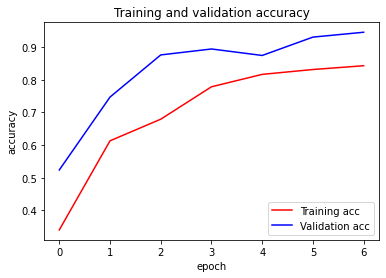

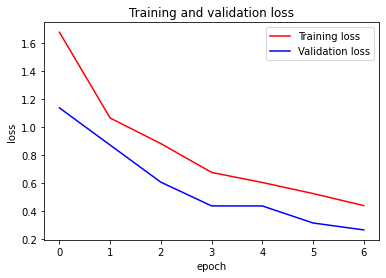

In [15]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

Model Evaluation on Testing Set

In [16]:
model.evaluate(test_data, test_labels)

19/19 [==============================] - 0s 4ms/step - loss: 0.6898 - acc: 0.7715


[0.6898337006568909, 0.7715231776237488]

Classification metrics

In [17]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[1.62911639e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.54945338e-01 0.00000000e+00]
   [9.73956734e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.17594540e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.81750190e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.90735173e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    4.19955105e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.68091035e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.71550429e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 2.10540801e-01 ... 0.00000000e+00
    3.51710707e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 6.56097829e-01 ... 0.00000000e+00
    1.31016910e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 4.20265198e-0

In [18]:
animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

 butterflies       0.78      0.94      0.85       100
    chickens       0.95      0.70      0.80       100
   elephants       0.86      0.74      0.80       100
      horses       0.93      0.77      0.84       100
     spiders       0.97      0.37      0.54       100
   squirells       0.86      0.60      0.70       104

   micro avg       0.88      0.69      0.77       604
   macro avg       0.89      0.69      0.76       604
weighted avg       0.89      0.69      0.76       604
 samples avg       0.69      0.69      0.69       604



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix

In [19]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
#label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [20]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [21]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
#Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


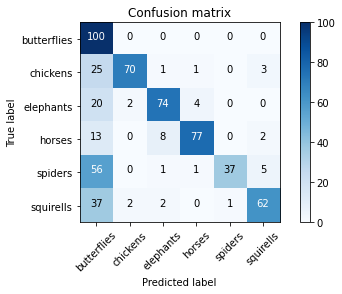

In [22]:
plot_confusion_matrix(confusion_matrix, ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'])

Normalized confusion matrix


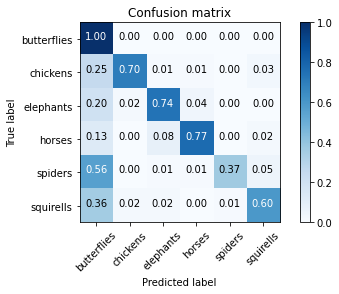

In [23]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells'],
                     normalize=True)

Testing images on model

In [24]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [32]:
import numpy as np 
from keras.models import Sequential 
from keras.layers import Dense 

# create the model
model = Sequential()
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# generate some dummy data
X = np.random.rand(100, 5)
y = np.random.randint(2, size=(100,))

# train the model
model.fit(X, y, epochs=10, batch_size=32)

# make predictions and get probabilities
probas = model.predict(X)
y_pred = np.round(probas)

Epoch 1/10
4/4 [==============================] - 1s 6ms/step - loss: 0.7483 - accuracy: 0.4900
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7427 - accuracy: 0.4800
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7381 - accuracy: 0.4600
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7351 - accuracy: 0.4700
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7317 - accuracy: 0.4800
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7285 - accuracy: 0.4700
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7265 - accuracy: 0.4900
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7243 - accuracy: 0.4700
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7224 - accuracy: 0.4700
Epoch 10/10
4/4 [==============================] - 0s 2ms/step


In [25]:
def test_single_image(path):
    animals = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    # preds = model.predict_proba(bt_prediction)
    preds = np.argmax(model.predict(bt_prediction), axis=-1)
    for idx, animal, x in zip(range(0,6), animals , range(preds[0])):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    # class_predicted = model.predict_classes(bt_prediction)
    class_predicted = np.argmax(model.predict(bt_prediction), axis=-1)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [30]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator

#path of image that is used for testing
path = '/content/drive/MyDrive/fauna-image-classification-using-convolutional-neural-network-master/sampleDataset/test/testimage3.jpeg'

In [ ]:
# !pip install q keras==2.6.0

In [30]:
# print(keras.__version__)

2.9.0


[INFO] loading and preprocessing image...
1/1 [==============================] - 0s 18ms/step
Final Decision:
.
..
...
1/1 [==============================] - 0s 22ms/step
ID: 0, Label: butterflies


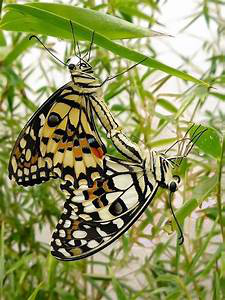

In [31]:
test_single_image(path)